In [1]:
import string
import re
from itertools import combinations
import os
import requests
from multiprocess import Process, Manager
import numpy as np
from scipy.spatial import distance
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.downloader
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from octis.evaluation_metrics.diversity_metrics import TopicDiversity

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

random_state = 42

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/Users/tim/opt/anaconda3/envs/masterarbeit

In [2]:
articles = pd.read_csv(
    './data/rwe_news_prep.csv', 
    delimiter=';'
)

articles = articles.sample(
    frac=1,
    random_state=random_state,
).reset_index(drop=True)#.head(1000)

articles = articles.dropna(
    subset=['time_stamp', 'title']
)

# clip news on weekend to friday
articles['time_stamp'] = pd.to_datetime(articles['time_stamp'])
articles['time_stamp'] -= pd.to_timedelta((articles['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')

In [3]:
punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')
stop_words.extend(['rwe', 'aktiengesellschaft', 'rweoy', 'adr', 'innogy', 'igy', 'dgapdd'])

lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    X = X.replace("\n", " ")
    X = X.replace("\t", " ")
    X = re.sub(r'[^A-Za-z0-9 ]+', '', X)
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

# Data Understanding

time_stamp  \
0    2008-02-21   
1    2013-10-14   
2    2014-03-11   
3    2008-11-13   
4    2010-11-04   
...         ...   
3075 2012-10-09   
3076 2011-07-15   
3077 2011-07-29   
3078 2011-11-03   
3079 2011-01-06   

                                                                                                                                                                           title  
0                                                                                                        RENEWABLES - German Repower, RWE Innogy To Negotiate 1,900 MW Contracts  
1                                                                                                                  German RWE, Eon call for nuclear fuel tax exemptions - report  
2                                                                                                                        RWE reportedly starts accepting final bids for DEA unit  
3                                                                                                           RENEWABLES - RWE , municipal company build biomass plant for EUR 30m  
4                                                                                                             RWE shows interest in 2,400 MW HPP construction in Serbia - report  
...                                                                                                                                                                          ...  
3075                                                                                                                         - RWE Dea starts production from gas field Devenick  
3076                                                                                                                  Deal snapshot: RWE ANNOUNCES DEAL TO SELL 74.9% IN AMPRION  
3077                                                                        Month to July 29: RWE weakens below Moving Average Price (MAP), with 50-day MAP trailing 200-day MAP  
3078  Additional crude oil reserves assumed to exist in northern Germany RWE Dea submits applications for exploration wells off the coast of Schleswig-Holstein and Lower Saxony  
3079                     WIPO ASSIGNS PATENT TO RWE FOR "DEVICE AND METHOD FOR METERING THE ENERGY QUANTITY IN THE CHARGING STATION FOR AN ELECTRIC VEHICLE" ( GERMAN INVENTORS)  

[3080 rows x 2 columns]

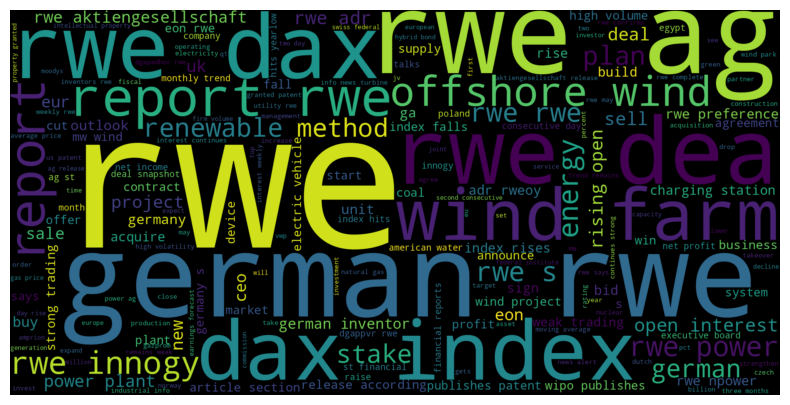

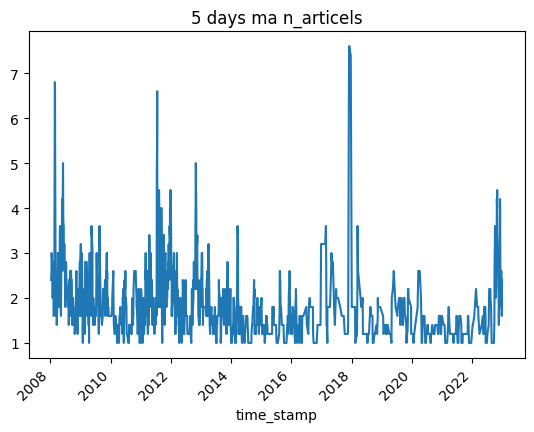

In [4]:
display(articles)

articles_string = articles['title'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

articles.groupby('time_stamp').size().rolling(5).mean().plot(kind='line',title='5 days ma n_articels')
plt.xticks(rotation = 45)
plt.show()

# Topic Modeling

In [5]:
def create_topic_activity(doc_topic: pd.DataFrame, docs: pd.DataFrame) -> pd.DataFrame:
    # insert time_stamp
    doc_topic['time_stamp'] = pd.to_datetime(docs['time_stamp'])

    # sum up news by date and company
    doc_topic['time_stamp'] = doc_topic['time_stamp'].dt.date
    count = doc_topic.groupby('time_stamp').size() + 0.0001
    topic_activity = doc_topic.groupby(['time_stamp']).sum()
    #topic_activity = topic_activity.div(count, axis=0)
    topic_activity['count'] = count

    # insert 0 for days with no news
    topic_activity.index = pd.to_datetime(topic_activity.index)
    topic_activity = topic_activity.asfreq('D', fill_value=0)

    # drop weekends
    topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

    # add random validation topic
    #np.random.seed(random_state)
    topic_activity['topic_val'] = np.random.normal(
        scale=0.05,
        loc=-0.05,
        size=len(topic_activity),
    ) * topic_activity.max().max()
    topic_activity['topic_val'] = topic_activity['topic_val'].clip(lower=0).round(0)

    # compute moving average
    #topic_activity = topic_activity.ewm(halflife=5).mean()
    
    topic_activity.plot(
        kind='line',
        title='Topic Activity',
        subplots=True,
        figsize=(15, 10)
    )
    plt.tight_layout()
    plt.show()
    
    return topic_activity

## LDA

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data preparation

In [7]:
%%time
lda_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.1,
    min_df=2,
    ngram_range=(1,2)
)

X = lda_vectorizer.fit_transform(articles['title'])
lda_tokens = articles['title'].apply(lda_vectorizer.build_analyzer()).to_list()

print(f'n_articels: {X.shape[0]}')
print(f'n_features (words/ngrams): {X.shape[1]}')

n_articels: 3080
n_features (words/ngrams): 4349
CPU times: user 4.92 s, sys: 214 ms, total: 5.13 s
Wall time: 5.14 s


### Evaluation

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 6 leaked semaphore objects to clean up at shutdown
  warnings.warn('resour

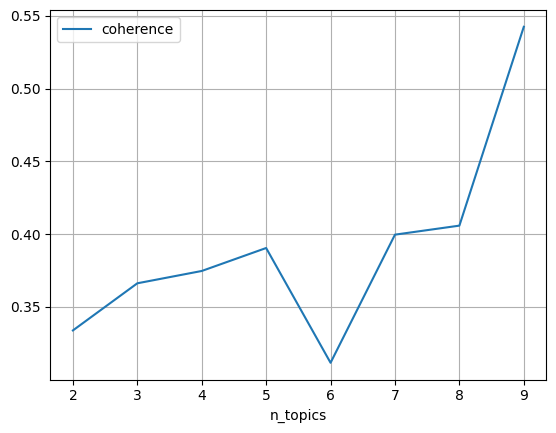

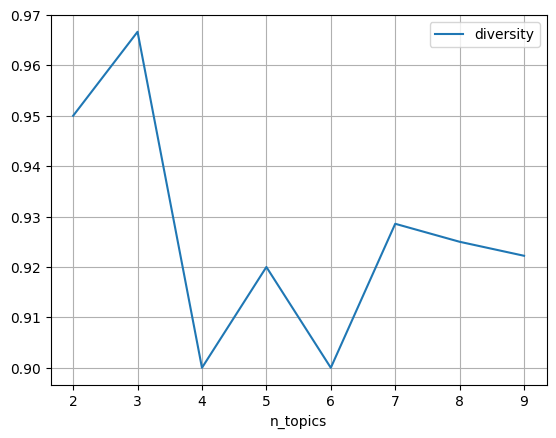

CPU times: user 961 ms, sys: 538 ms, total: 1.5 s
Wall time: 21.2 s


In [8]:
%%time
def compute_metrics(topic_coherence, t):
    # train lda
    lda = LatentDirichletAllocation(
        n_components=t,
        doc_topic_prior=None,
        topic_word_prior=None,
        learning_method='online',
        random_state=random_state,
    )
    lda.fit(X)

    # compute top words in topic
    topic_word = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    topic_word = pd.DataFrame(
        topic_word,
        index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
        columns=lda_vectorizer.get_feature_names()
    )
    topic_words = list()
    for topic in topic_word.index:
        topic_desc = list(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].columns)
        topic_words.append(topic_desc[:10])
    
    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=lda_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()

    metric = TopicDiversity(topk=10)
    diversity = metric.score({'topics': topic_words})
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])

    
dictionary = corpora.Dictionary(lda_tokens)
# test hyper params
with Manager() as manager:
    topic_coherence = manager.list()
    processes = []
    max_topics = 10
    for t in range(2, max_topics):
        p = Process(target=compute_metrics, args=(topic_coherence, t))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    topic_coherence = list(topic_coherence)

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()


### Training

In [9]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=5,
    doc_topic_prior=None,
    topic_word_prior=None,
    learning_method='online',
    random_state=random_state,
)
lda_model.fit(X)

CPU times: user 2.69 s, sys: 37.4 ms, total: 2.73 s
Wall time: 2.77 s


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

### Results

In [10]:
#pyLDAvis.sklearn.prepare(lda_model, X, lda_vectorizer)

In [11]:
# prepare doc topic distribution
lda_doc_topic = lda_model.transform(X)
lda_doc_topic = pd.DataFrame(
    lda_doc_topic,
    columns=[f'topic_{i}' for i in range(1, lda_doc_topic.shape[1]+1)]
)
display(lda_doc_topic)

# calculate topic distribution
topic_size = (lda_doc_topic.sum() / len(lda_doc_topic)).to_frame().transpose()
display(topic_size)

# prepare topic word distribution
topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=lda_vectorizer.get_feature_names()
).round(5)

# display topics
lda_topics = dict()
for topic in topic_word.index:
    lda_topics[topic] = list(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :5].columns)
    #display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

lda_topics = pd.DataFrame(lda_topics).transpose()
display(lda_topics)

topic_1   topic_2   topic_3   topic_4   topic_5
0     0.033545  0.033456  0.033334  0.866261  0.033404
1     0.022380  0.910774  0.022223  0.022273  0.022351
2     0.926464  0.018183  0.018204  0.018956  0.018194
3     0.919231  0.020021  0.020000  0.020203  0.020545
4     0.040004  0.238756  0.240267  0.040170  0.440803
...        ...       ...       ...       ...       ...
3075  0.016741  0.016690  0.016678  0.933222  0.016669
3076  0.016684  0.016727  0.016667  0.016758  0.933165
3077  0.010532  0.010526  0.957876  0.010536  0.010531
3078  0.517373  0.055744  0.132798  0.193368  0.100717
3079  0.009094  0.009133  0.009098  0.009092  0.963583

[3080 rows x 5 columns]

topic_1   topic_2   topic_3  topic_4   topic_5
0  0.257375  0.142555  0.184039  0.24935  0.166681

0       1          2          3            4
topic_1  germany  profit        eur        dea          gas
topic_2    power  patent     method        eon  application
topic_3     rise   index        dax  dax index         fall
topic_4     wind    farm  wind farm        dea     offshore
topic_5    plant  energy      power       deal      station

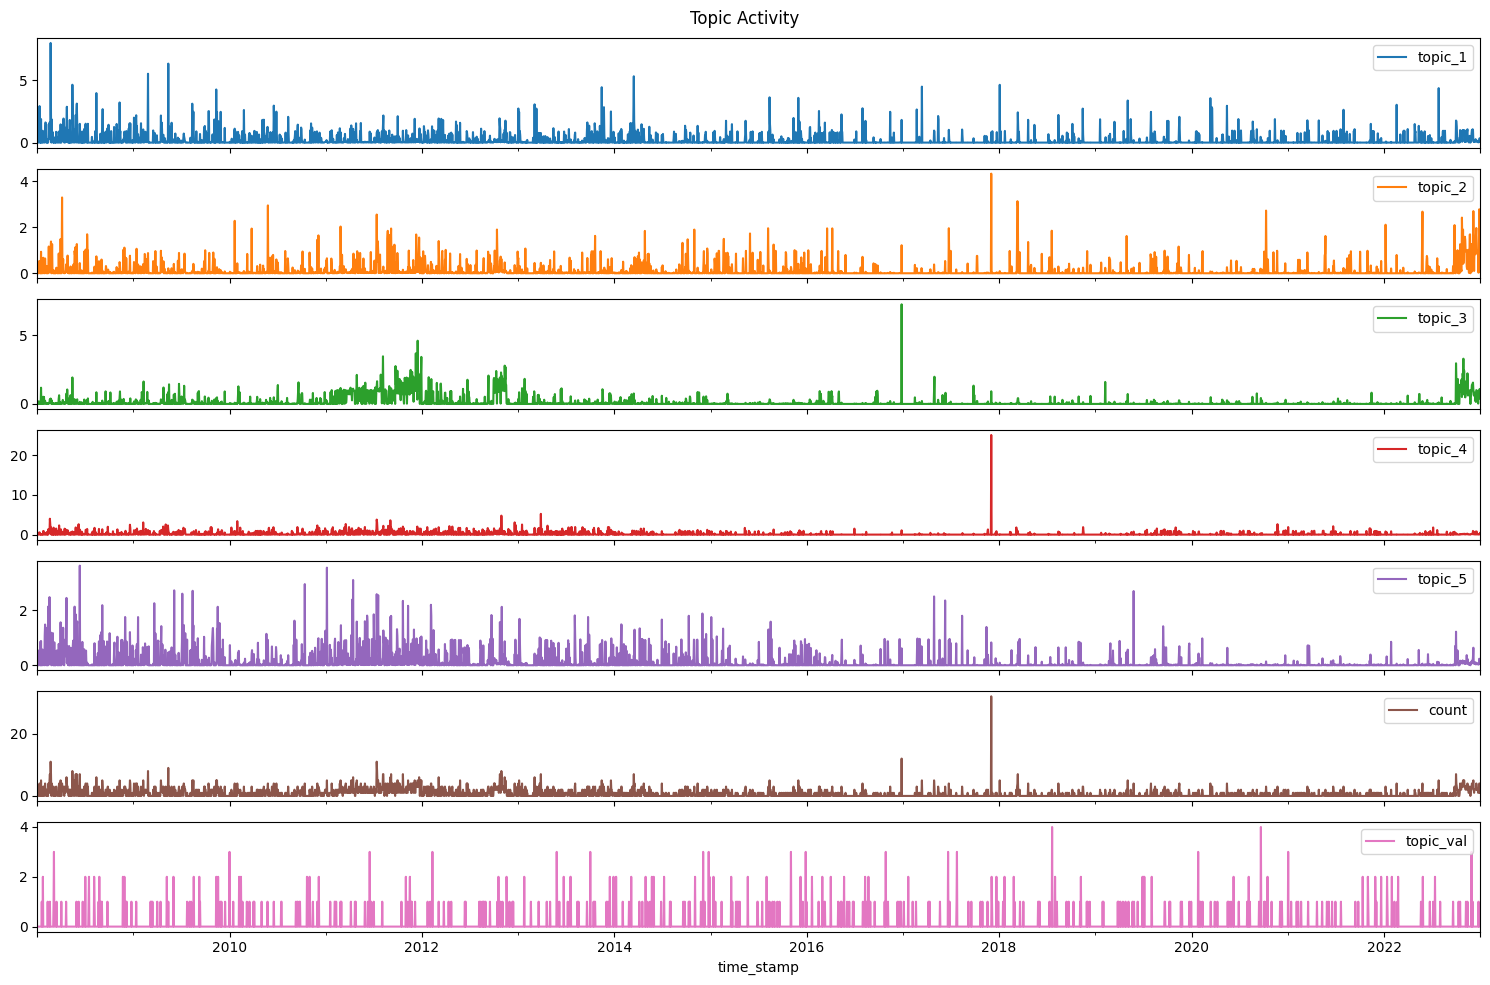

In [12]:
lda_topic_activity = create_topic_activity(lda_doc_topic, articles)

# safe to csv
lda_topic_activity.to_csv('data/rwe_lda_topic_activity.csv', sep=';')

## BERT Topic

In [13]:
from bertopic import BERTopic

2023-03-26 00:30:38.725748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarn

### Data preparation

In [14]:
bert_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    ngram_range=(1, 2)
)

bert_dtm = bert_vectorizer.fit_transform(articles['title'])

### Evaluation

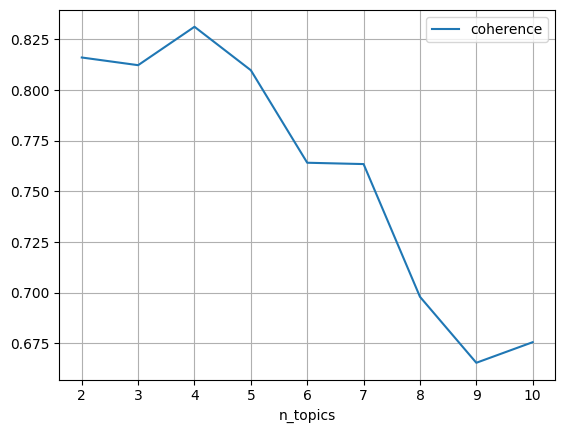

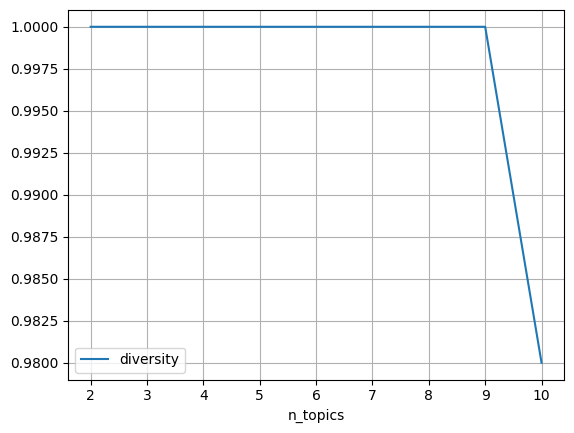

CPU times: user 10min 51s, sys: 23.5 s, total: 11min 15s
Wall time: 3min 34s


In [15]:
%%time
def compute_coherence_bertopic(topic_coherence, t):
    # reduce topics
    bertopic.reduce_topics(articles['title'], t)
    topics, probs = bertopic.transform(articles['title'])
    
    # Extract features for Topic Coherence evaluation
    topic_words = [[words for words, _ in bertopic.get_topic(topic)] for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=bert_tokens, 
        dictionary=dictionary, 
        topn=10,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()

    metric = TopicDiversity(topk=10)
    diversity = metric.score({'topics': topic_words})
    
    # append to shared list
    topic_coherence.append([t, coherence, diversity])


os.environ["TOKENIZERS_PARALLELISM"] = 'false'
# train bertopic
bertopic = BERTopic(
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)
bertopic.fit(articles['title'])

# build bert tokens and dictonary
bert_tokens = articles['title'].apply(bertopic.vectorizer_model.build_analyzer()).to_list()
dictionary = corpora.Dictionary(bert_tokens)

# find optimal number of topics
topic_coherence = list()
max_topics = 10
for t in range(max_topics, 1, -1):
    compute_coherence_bertopic(topic_coherence, t)
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

# plot
topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence', 'diversity'])
topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['coherence'], grid=True)
plt.show()

topic_coherence.sort_values('n_topics').plot(x='n_topics', y=['diversity'], grid=True)
plt.show()

### Training

In [16]:
%%time
bert_model = BERTopic(
    nr_topics=5,
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)

bert_model.fit(articles['title'])

topics, probs = bert_model.transform(articles['title'])

topics = bert_model.reduce_outliers(
    articles['title'], topics,
    strategy='embeddings',
    probabilities=probs,
    threshold=0.2
)

bert_doc_topic = pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
)
bert_doc_topic = pd.get_dummies(bert_doc_topic)
bert_doc_topic.columns = bert_model.get_topic_info()['Name'].values

CPU times: user 3min 17s, sys: 9.3 s, total: 3min 27s
Wall time: 37.9 s


### Results

In [17]:
display(bert_model.get_topic_info())

pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
).groupby('topic').size()

Topic  Count                                    Name
0     -1   1817            -1_german_report_power_plant
1      0    353          0_wind_farm_wind farm_offshore
2      1    337              1_rise_index_dax index_dax
3      2    273  2_release_article_board_accord article
4      3    169         3_patent_method_charge_inventor
5      4    131                   4_dea_gas_egypt_field

topic
-1    993
 0    600
 1    525
 2    442
 3    254
 4    266
dtype: int64

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  icoord = scp.array(P["icoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  dcoord = scp.array(P["dcoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  ordered_labels = scp.array(P["ivl"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  color_list 

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



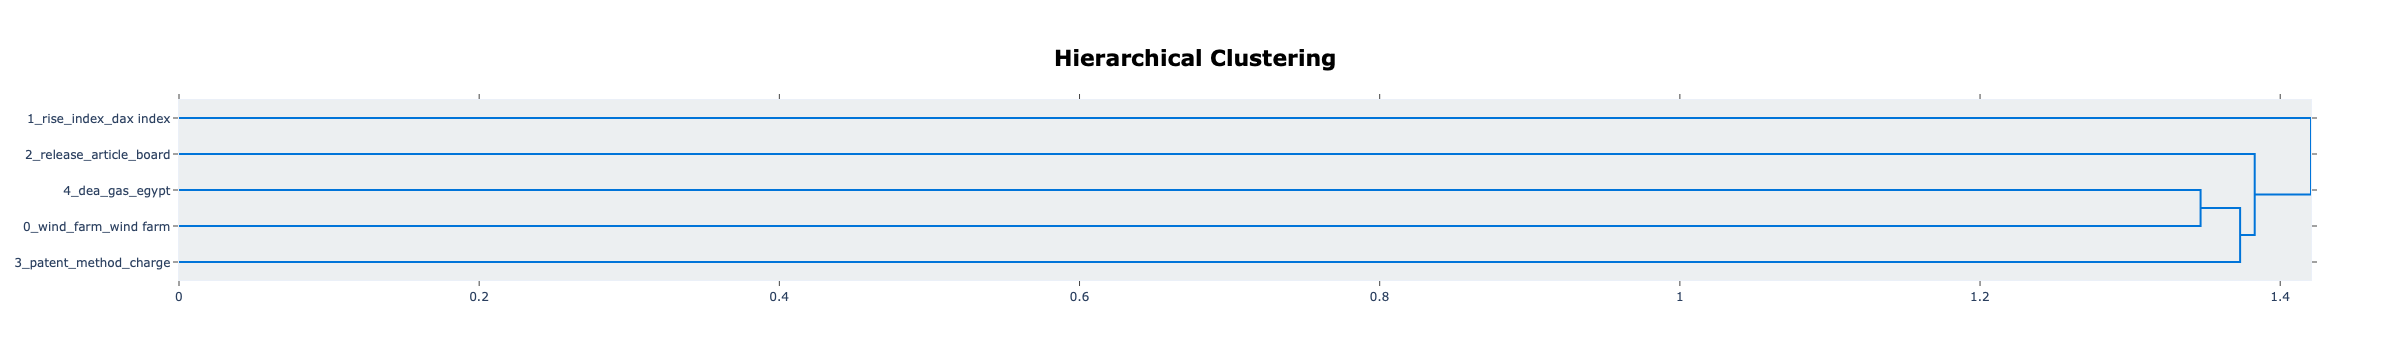

In [18]:
bert_model.visualize_hierarchy()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



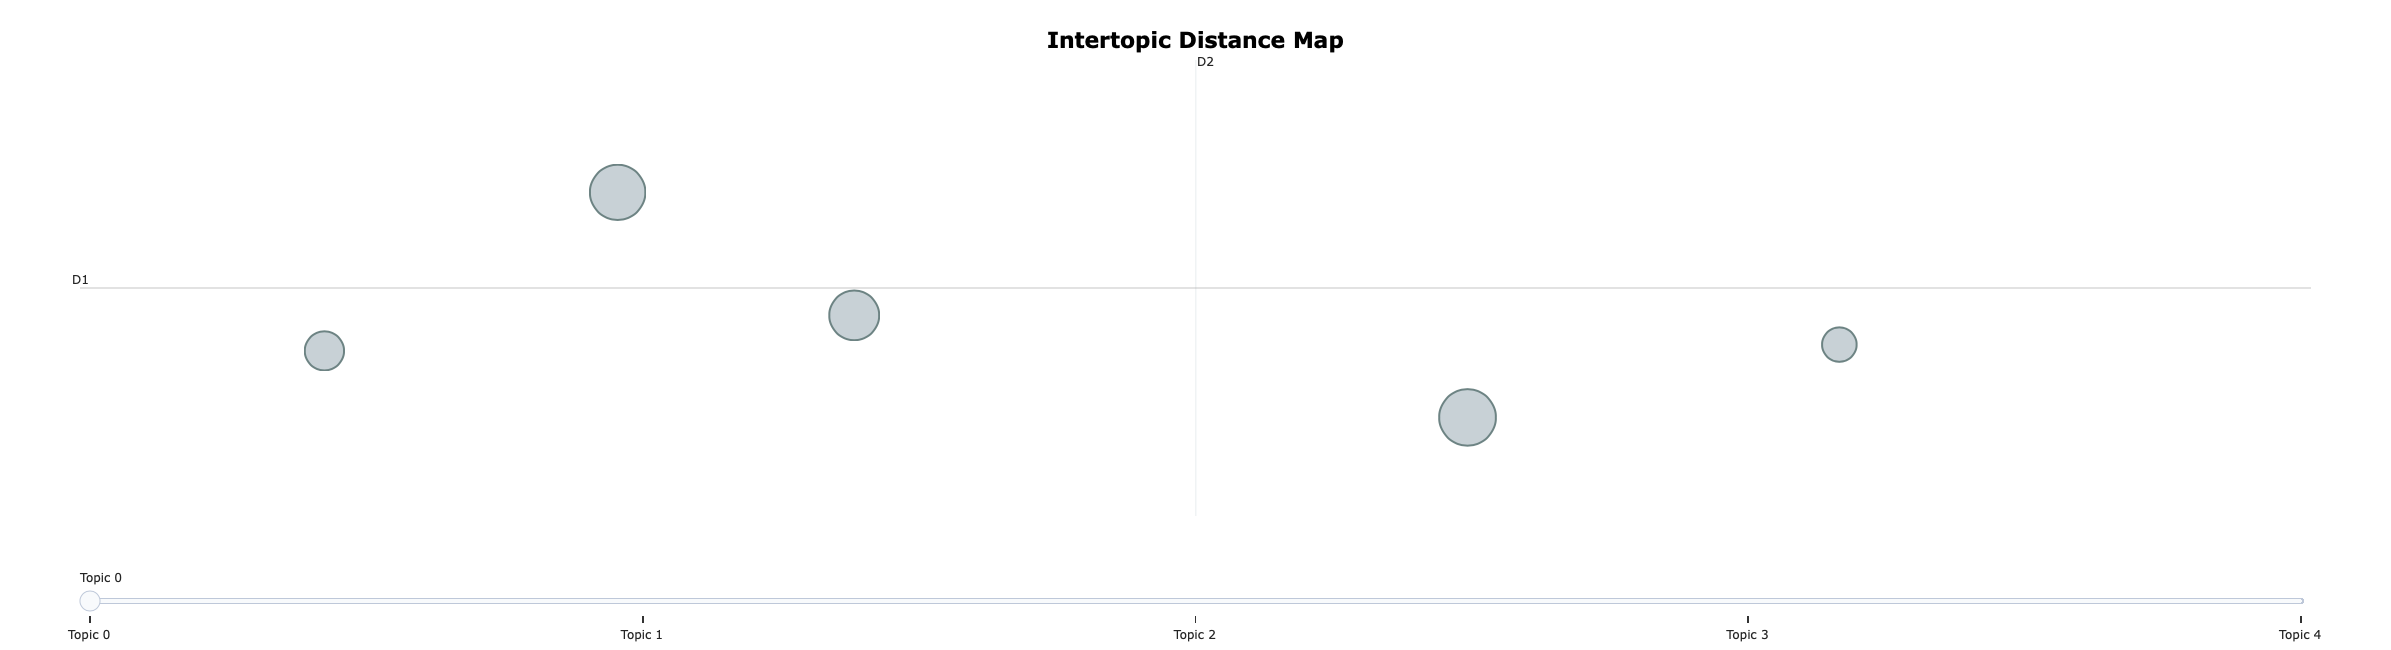

In [19]:
bert_model.visualize_topics()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



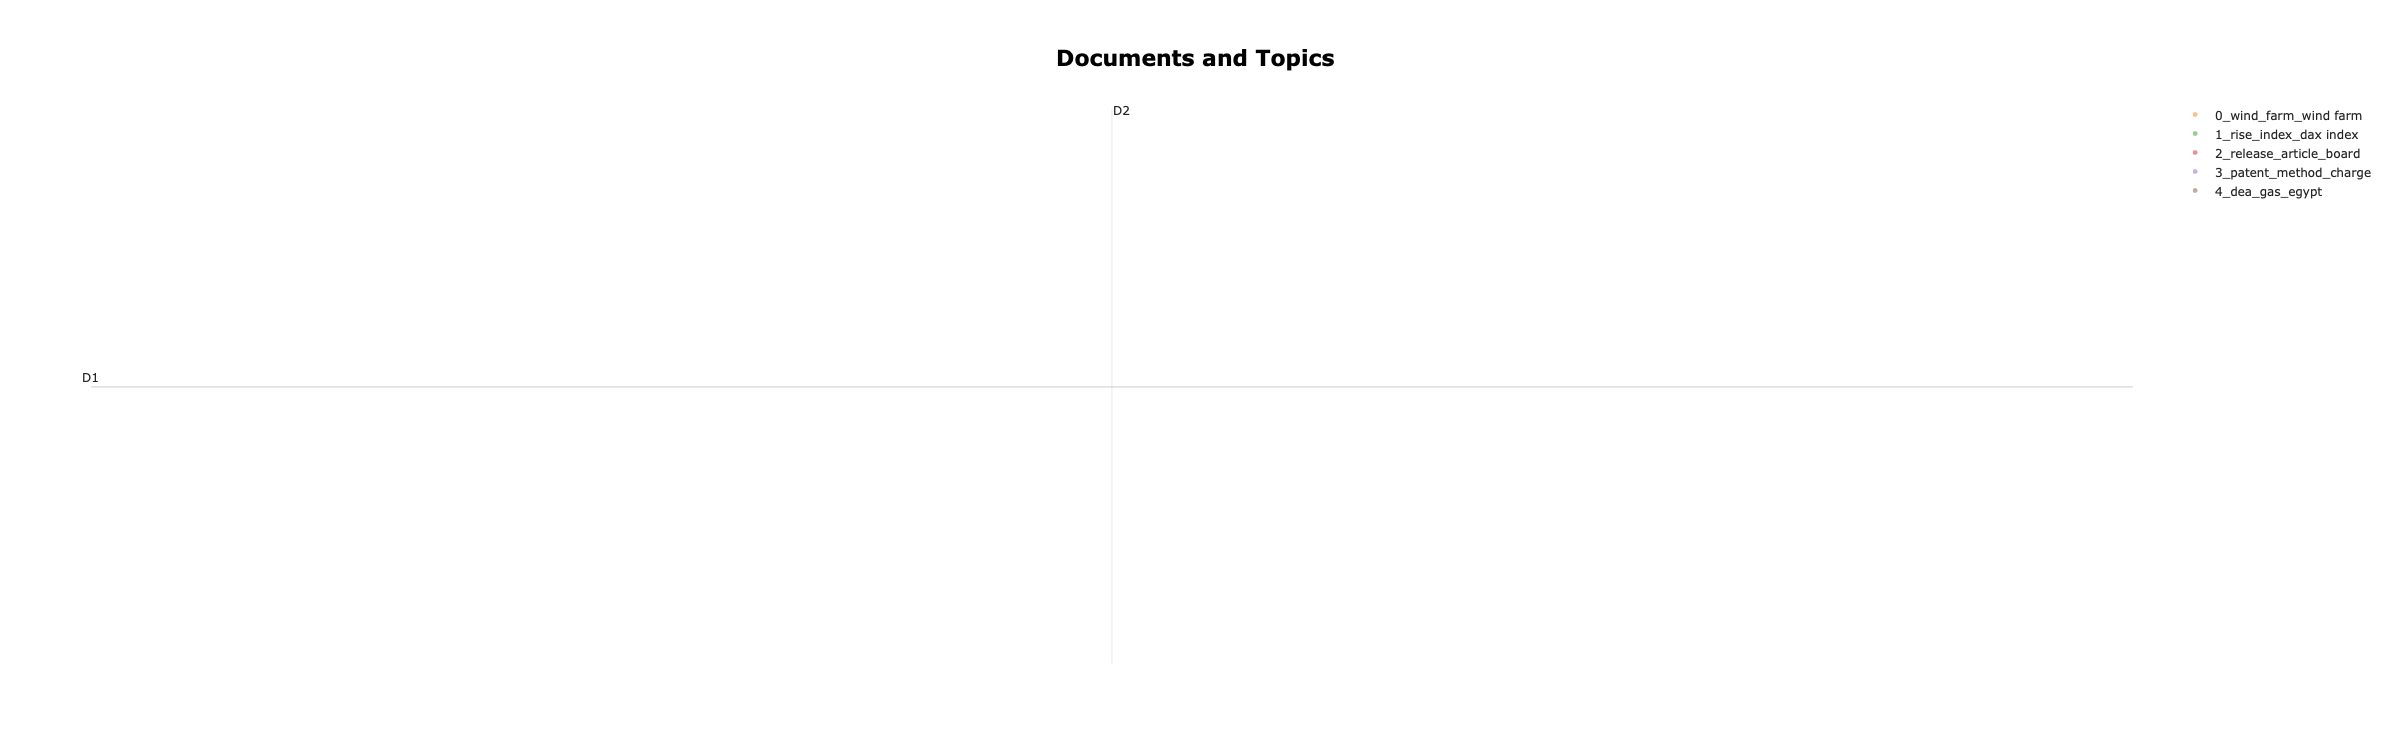

In [20]:
bert_model.visualize_documents(articles['title'])

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



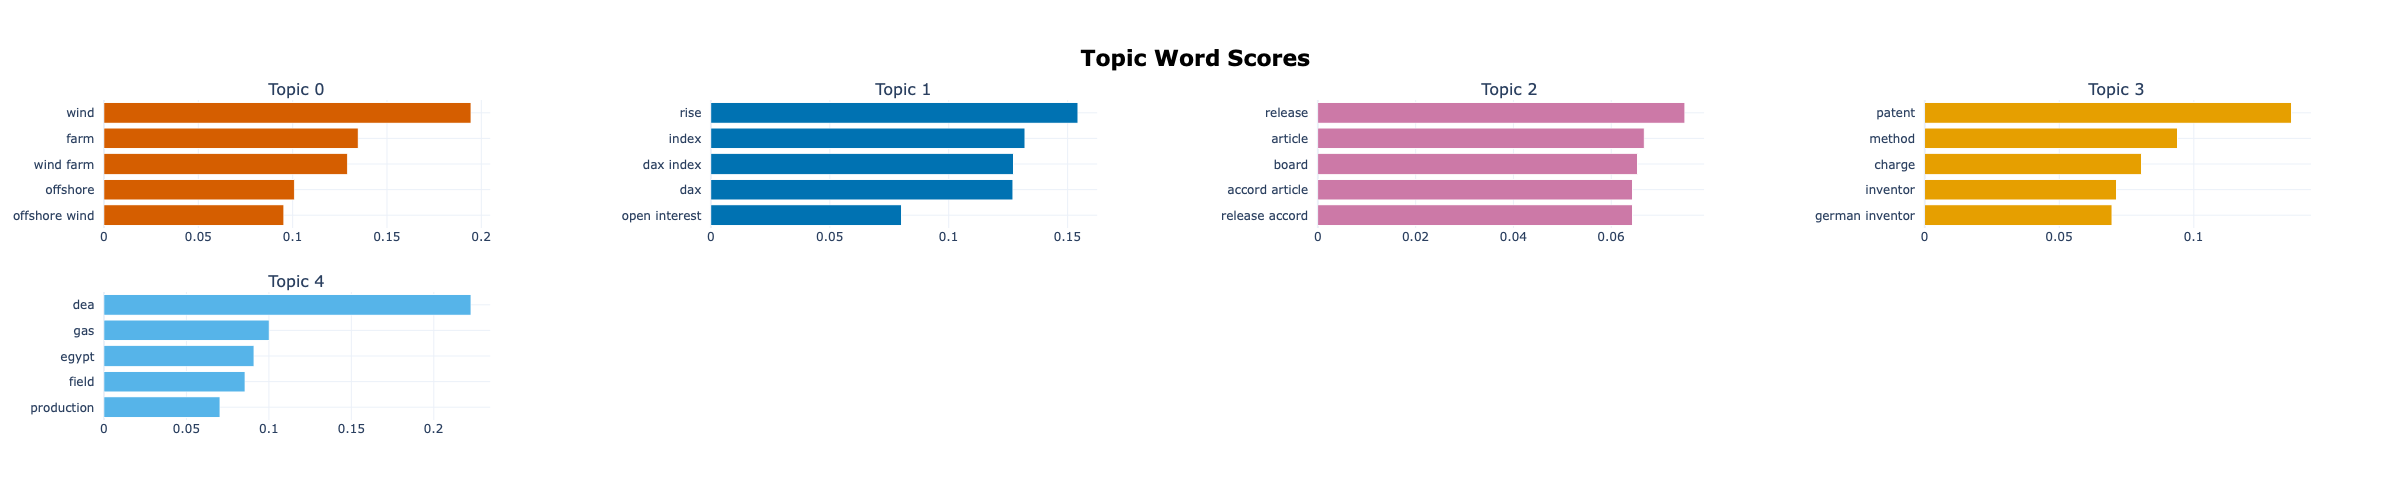

In [21]:
bert_model.visualize_barchart()

In [22]:
doc_top_assignment = dict(sorted(bert_model.get_representative_docs().items()))
keys = list(doc_top_assignment.keys())

for key in keys:
    doc_top_assignment[bert_model.get_topic_info().iloc[int(key)+1, 2]] = doc_top_assignment[key][:5]
    del doc_top_assignment[key]
    
display(doc_top_assignment)

{'0_wind_farm_wind farm_offshore': ['RWE opens service base for 295- MW wind farm in German waters',
  'RWE opens Welsh wind farm',
  "RWE starts construction of new facilities for RWE Innogy UK's wind farm",
  'RWE Renewables begins operations at 195.5- MW Ga. solar farm',
  'RWE to invest up to EUR 150m in Moroccan solar project - report'],
 '1_rise_index_dax index_dax': ['RWE [ DAX index] hits year-low 10th time in three months',
  'RWE [ DAX index] hits year-low 8th time in one month and 10th time in three months',
  'RWE [ DAX index] hits year-low 8th time in one month and 12th time in three months',
  'RWE resolutely implements package of measures',
  'RWE strengthens above MAP'],
 '2_release_article_board_accord article': ['DGAP-Adhoc: RWE AG : Executive Board raises overall earnings forecast for the full year 2022',
  'DGAP-Adhoc: RWE Aktiengesellschaft: RWE raises Group earnings forecast for fiscal 2022',
  'EQS -Adhoc: RWE Aktiengesellschaft: RWE AG raises Group earnings fore

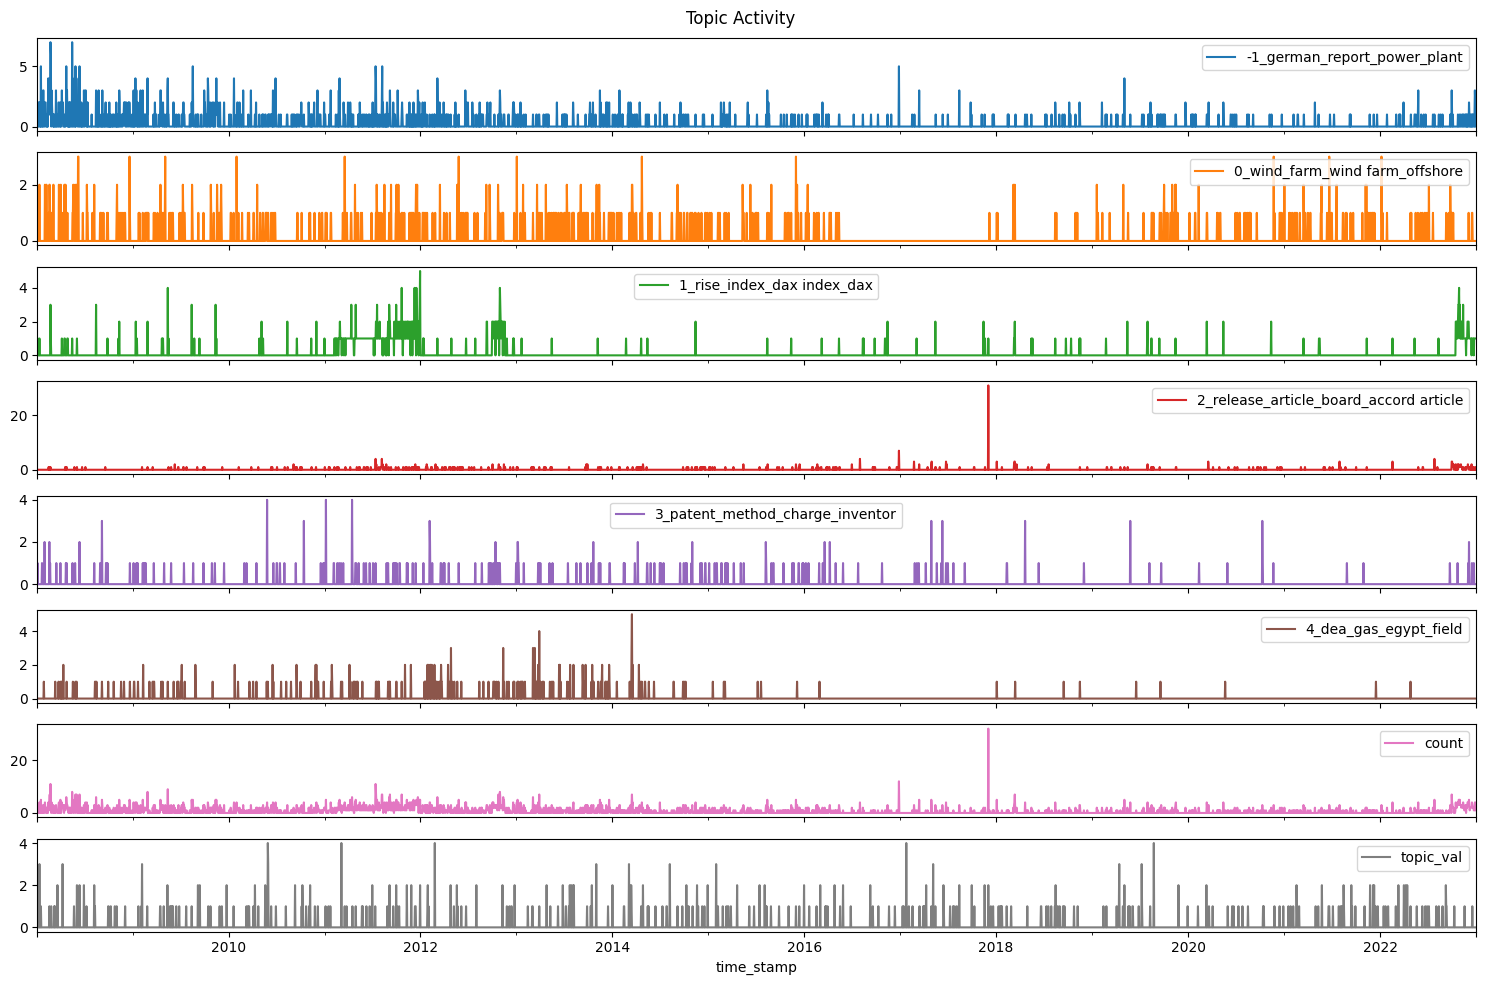

In [23]:
# Topic activity for Baseline
bert_topic_activity = create_topic_activity(bert_doc_topic, articles)
#bert_topic_activity = bert_topic_activity[bert_topic_activity.index < '2016-01-01']

# safe to csv
bert_topic_activity.to_csv('data/rwe_bert_topic_activity.csv', sep=';')

# Dataset for Advanced Approach
dataset = articles.copy()
dataset['topic'] = topics
dataset.to_csv('data/rwe_news_dataset.csv', sep=';', index=False)